# Uniswap ETHDAI Analysis


To use, please follow the following tutorial for how to configure big query: https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries


In this notebook, we are illustrating how to query the EthDai Uniswap smart contract and analysis it's data. see [Uniswap_Model.ipynb](Uniswap_Model.ipynb) for a cadCAD model around Uniswap.

In [1]:
FROM_BLOCK_TIMESTAMP = "'2018-11-02 00:00:00'" 
TO_BLOCK_TIMESTAMP = "'2019-09-23 23:59:59'" 
MY_TIMEOUT = 300

# relevant Events signatures
events_signatures = {
    'TokenPurchase': 'TokenPurchase(address,uint256,uint256)', #event({buyer: indexed(address), eth_sold: indexed(uint256(wei)), tokens_bought: indexed(uint256)})
    'EthPurchase': 'EthPurchase(address,uint256,uint256',#,event({buyer: indexed(address), tokens_sold: indexed(uint256), eth_bought: indexed(uint256(wei))})
    'AddLiquidity': 'AddLiquidity(address,uint256,uint256)',#,event({provider: indexed(address), eth_amount: indexed(uint256(wei)), token_amount: indexed(uint256)})
    'RemoveLiquidity': 'RemoveLiquidity(address,uint256,uint256)',#,event({provider: indexed(address), eth_amount: indexed(uint256(wei)), token_amount: indexed(uint256)})
    'Transfer': 'Transfer(address,address,uint256)',#,event({_from: indexed(address), _to: indexed(address), _value: uint256})
    'Approval': 'Approval(address,address,uint256)'#,event({_owner: indexed(address), _spender: indexed(address), _value: uint256})
}
events_hashes = {
    'cd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50f': 'TokenPurchase',
    '7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b353984238705': 'EthPurchase',
    '06239653922ac7bea6aa2b19dc486b9361821d37712eb796adfd38d81de278ca': 'AddLiquidity',
    '0fbf06c058b90cb038a618f8c2acbf6145f8b3570fd1fa56abb8f0f3f05b36e8': 'RemoveLiquidity',
    'ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef': 'Transfer',
    '8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925': 'Approval'
}
contracts = {
    '0x09cabEC1eAd1c0Ba254B09efb3EE13841712bE14'.lower(): 'DAI'
}
contracts

{'0x09cabec1ead1c0ba254b09efb3ee13841712be14': 'DAI'}

In [2]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', 70)

In [3]:
client = bigquery.Client()
query = """
SELECT 
  events.transaction_hash AS transactionHash,
  events.transaction_index,
  txns.from_address AS transaction_sender, 
  events.address,
  events.data,
  events.topics,
  events.block_timestamp,
  events.block_number AS blockNumber_dec
FROM
  `bigquery-public-data.ethereum_blockchain.logs` AS events
INNER JOIN
  `bigquery-public-data.ethereum_blockchain.transactions` AS txns
ON
  events.transaction_hash = txns.hash
WHERE TRUE
  AND events.block_timestamp >= {from_block_ts} 
  AND events.block_timestamp <= {to_block_ts}
  AND txns.block_timestamp >= {from_block_ts} --might seem redundant, but because of partitioning this reduces cost
  AND txns.block_timestamp <= {to_block_ts} --might seem redundant, but because of partitioning this reduces cost
  AND events.address IN ({contract_list})
""".format(
    from_block_ts=FROM_BLOCK_TIMESTAMP, 
    to_block_ts=TO_BLOCK_TIMESTAMP, 
    contract_list=(','.join(["'{}'".format(k) for k in list(contracts.keys())])))

query_job = client.query(query)
iterator = query_job.result(timeout=MY_TIMEOUT)
rows = list(iterator)
events = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
events['contract'] = events['address'].apply(lambda x: contracts[x])
events['event'] = events['topics'].apply(lambda x: events_hashes[x[0][2:]])
events = events.sort_values(['blockNumber_dec','transaction_index']).reset_index(drop=True)
events.head(10)

/home/danlessa/.anaconda3/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/danlessa/.anaconda3/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about serv


SELECT 
  events.transaction_hash AS transactionHash,
  events.transaction_index,
  txns.from_address AS transaction_sender, 
  events.address,
  events.data,
  events.topics,
  events.block_timestamp,
  events.block_number AS blockNumber_dec
FROM
  `bigquery-public-data.ethereum_blockchain.logs` AS events
INNER JOIN
  `bigquery-public-data.ethereum_blockchain.transactions` AS txns
ON
  events.transaction_hash = txns.hash
WHERE TRUE
  AND events.block_timestamp >= '2018-11-02 00:00:00' 
  AND events.block_timestamp <= '2019-09-23 23:59:59'
  AND txns.block_timestamp >= '2018-11-02 00:00:00' --might seem redundant, but because of partitioning this reduces cost
  AND txns.block_timestamp <= '2019-09-23 23:59:59' --might seem redundant, but because of partitioning this reduces cost
  AND events.address IN ('0x09cabec1ead1c0ba254b09efb3ee13841712be14')



,transactionHash,transaction_index,transaction_sender,address,data,topics,block_timestamp,blockNumber_dec,contract,event
0,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712eb796adfd38d81de278c...,2018-11-02 10:27:36+00:00,6629139,DAI,AddLiquidity
1,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x000000000000000000000000000000000000000000000001a055690d9db80000,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3e...,2018-11-02 10:27:36+00:00,6629139,DAI,Transfer
2,0xd53f01fc0cabbf4083da93a023ddb81de91320027077849ac982f7bc04b49279,97,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:33:56+00:00,6629171,DAI,EthPurchase
3,0x53172898dbe437c784f7e4ac757087b28d1b06aa6b72b81d4a6bb2bead50c93e,53,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:35:47+00:00,6629177,DAI,EthPurchase
4,0x6cef57fd37d7a2602c1236ff080c61c37e10980c7e3bd66de6f4e0ed52f16011,24,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 10:38:18+00:00,6629190,DAI,TokenPurchase
5,0x13d958222cbec3f6ae93e8f73af0f6ce800541db27a048258ac0645fc37e627e,281,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 10:39:55+00:00,6629198,DAI,TokenPurchase
6,0x51f662378a5e158bece87f19c5537fe69805e7163fe409f782000a66b0a44582,121,0x4defa30195094963cfac7285d8d6e6e523c7f90d,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 11:02:14+00:00,6629301,DAI,TokenPurchase
7,0x31f62df00bd7be033d6e4c959dfc7f596c2ec0902cda9d87c3b9c35a032b817d,51,0x4defa30195094963cfac7285d8d6e6e523c7f90d,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712eb796adfd38d81de278c...,2018-11-02 11:04:09+00:00,6629306,DAI,AddLiquidity
8,0x31f62df00bd7be033d6e4c959dfc7f596c2ec0902cda9d87c3b9c35a032b817d,51,0x4defa30195094963cfac7285d8d6e6e523c7f90d,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x000000000000000000000000000000000000000000000000002250f2cdb2da75,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3e...,2018-11-02 11:04:09+00:00,6629306,DAI,Transfer
9,0x865a3da7b390858ca91fc5b89885ec8e61115b8817442161b6d4b1afefefcdab,7,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 11:17:38+00:00,6629362,DAI,TokenPurchase


In [4]:
print('Block range: ' + str(events.blockNumber_dec.min()) + ' to ' + str(events.blockNumber_dec.max()))

Block range: 6629139 to 8608513


In [5]:
events.groupby(['contract','event']).transactionHash.count()

contract  event          
DAI       AddLiquidity        2694
          Approval             152
          EthPurchase        45840
          RemoveLiquidity     1787
          TokenPurchase      46266
          Transfer            4747
Name: transactionHash, dtype: int64

^ As expected, most events refer to trades (EthPurchase and TokenPurchase)

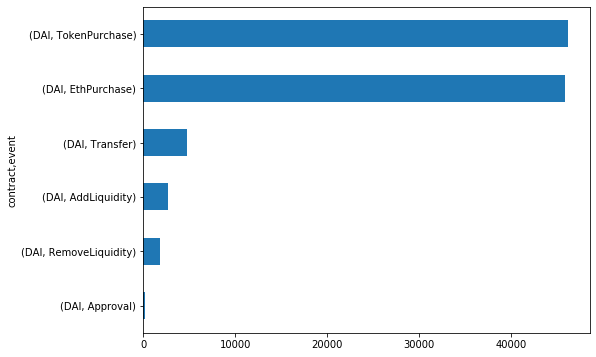

In [6]:
event_counts = events.groupby(['contract','event']).transactionHash.count()
event_counts.sort_values().plot(kind='barh', figsize=(8, 6))

In [7]:
event_counts_df = event_counts.reset_index()
event_counts_df.columns = ['contract', 'event', 'count']
event_counts_df

,contract,event,count
0,DAI,AddLiquidity,2694
1,DAI,Approval,152
2,DAI,EthPurchase,45840
3,DAI,RemoveLiquidity,1787
4,DAI,TokenPurchase,46266
5,DAI,Transfer,4747


In [8]:
events['contract_event'] = events['contract'] + events['event']
events['block_group'] = events['blockNumber_dec'].apply(lambda x: int(x/10000))

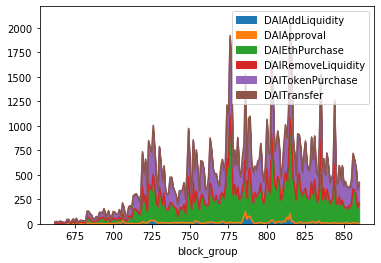

In [9]:
areaplot = events.groupby(['block_group','contract_event']).transactionHash.count().reset_index().pivot(index='block_group', columns='contract_event', values='transactionHash')#.plot.area()
areaplot.plot.area()
plt.legend(loc=1)

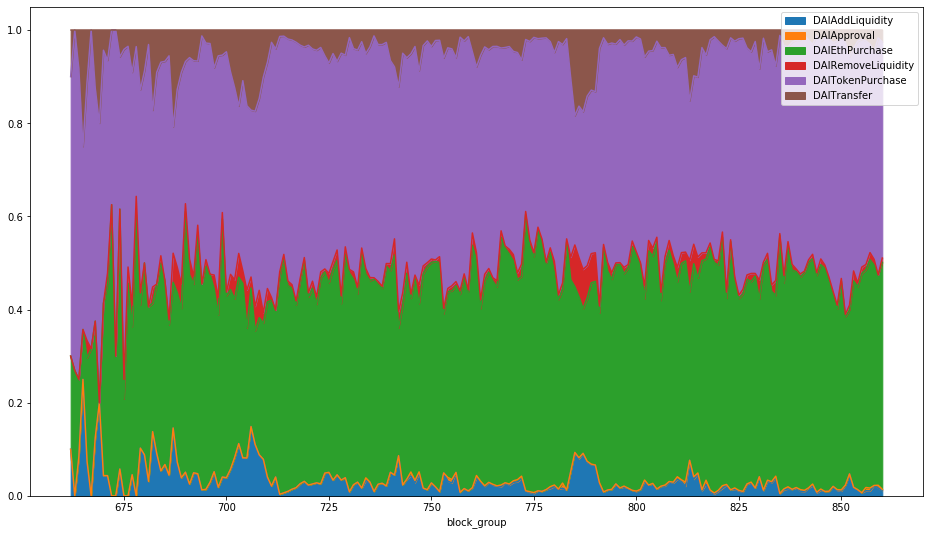

In [10]:
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

Remove Transfers and Approvals, as we won't need them going further

In [11]:
# events = events[~events.event.isin(['Transfer','Approval'])]
# events = events.drop('data', axis='columns')

In [12]:
events['agent'] = '0x' + events['topics'].apply(lambda x: x[1][26:66])

In [13]:
def getEthDeltaFromTopics(topics):
    event_hash = topics[0][2:]
    if events_hashes[event_hash] == 'TokenPurchase':
        return int(topics[2],16)
    if events_hashes[event_hash] == 'EthPurchase':
        return -int(topics[3],16)
    if events_hashes[event_hash] == 'AddLiquidity':
        return int(topics[2],16)
    if events_hashes[event_hash] == 'RemoveLiquidity':
        return -int(topics[2],16)
    return 0
    
def getTokenDeltaFromTopics(topics):
    event_hash = topics[0][2:]
    if events_hashes[event_hash] == 'TokenPurchase':
        return -int(topics[3],16)
    if events_hashes[event_hash] == 'EthPurchase':
        return int(topics[2],16)
    if events_hashes[event_hash] == 'AddLiquidity':
        return int(topics[3],16)
    if events_hashes[event_hash] == 'RemoveLiquidity':
        return -int(topics[3],16)
    return 0
    
def getUNIDeltaFromTopics(topics):
    event_hash = topics[0][2:]
    if events_hashes[event_hash] == 'Transfer':
        if topics[1] == '0x0000000000000000000000000000000000000000000000000000000000000000':
            return 1
        if topics[2] == '0x0000000000000000000000000000000000000000000000000000000000000000':
            return -1
    return 0
    
def getTradingVolumeFromTopics(topics):
    event_hash = topics[0][2:]
    if events_hashes[event_hash] == 'TokenPurchase':
        return int(topics[2],16)
    if events_hashes[event_hash] == 'EthPurchase':
        return int(topics[3],16)
    return 0
    
events['eth_delta'] = events['topics'].apply(getEthDeltaFromTopics)
events['token_delta'] = events['topics'].apply(getTokenDeltaFromTopics)

events['uni_delta'] = events['data'].apply(lambda x: 0 if x == '0x' else int(x,16))
events['uni_delta'] = events['uni_delta'] * events['topics'].apply(getUNIDeltaFromTopics)

events['eth_balance'] = events['eth_delta'].cumsum()
events['token_balance'] = events['token_delta'].cumsum()
events['UNI_supply'] = events['uni_delta'].cumsum()
events['invariant'] = events['eth_balance']*events['token_balance']
events.to_pickle('uniswap_events.pickle')
events.head()

,transactionHash,transaction_index,transaction_sender,address,data,topics,block_timestamp,blockNumber_dec,contract,event,contract_event,block_group,agent,eth_delta,token_delta,uni_delta,eth_balance,token_balance,UNI_supply,invariant
0,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712eb796adfd38d81de278c...,2018-11-02 10:27:36+00:00,6629139,DAI,AddLiquidity,DAIAddLiquidity,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,30000000000000000000,5900000000000000000000,0,30000000000000000000,5900000000000000000000,0,177000000000000000000000000000000000000000
1,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x000000000000000000000000000000000000000000000001a055690d9db80000,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3e...,2018-11-02 10:27:36+00:00,6629139,DAI,Transfer,DAITransfer,662,0x0000000000000000000000000000000000000000,0,0,30000000000000000000,30000000000000000000,5900000000000000000000,30000000000000000000,177000000000000000000000000000000000000000
2,0xd53f01fc0cabbf4083da93a023ddb81de91320027077849ac982f7bc04b49279,97,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:33:56+00:00,6629171,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-25326059253325791,5000000000000000000,0,29974673940746674209,5905000000000000000000,30000000000000000000,177000449620109111204145000000000000000000
3,0x53172898dbe437c784f7e4ac757087b28d1b06aa6b72b81d4a6bb2bead50c93e,53,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:35:47+00:00,6629177,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-10118429075406013,2000000000000000000,0,29964555511671268196,5907000000000000000000,30000000000000000000,177000629407442181233772000000000000000000
4,0x6cef57fd37d7a2602c1236ff080c61c37e10980c7e3bd66de6f4e0ed52f16011,24,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 10:38:18+00:00,6629190,DAI,TokenPurchase,DAITokenPurchase,662,0x11e4857bb9993a50c685a79afad4e6f65d518dda,10000000000000000,-1964761376358359468,0,29974555511671268196,5905035238623641640532,30000000000000000000,177000806558499339943044863018842396120272


In [14]:
trades = events[events.event.isin(['TokenPurchase','EthPurchase'])].copy()
trades['trading_volume'] = abs(trades['eth_delta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafc9f13090>]],
      dtype=object)

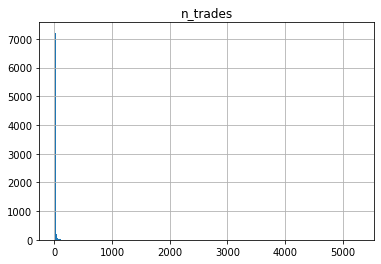

In [15]:
trades.groupby(['agent']).size().to_frame().rename(columns={0:'n_trades'}).hist(bins=300)

In [16]:
trades = trades.join(trades.groupby(['agent']).size().to_frame().rename(columns={0:'n_trades'}), on='agent')

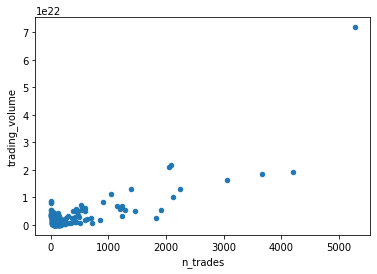

In [17]:
volume_frequency = trades.groupby(['n_trades']).trading_volume.sum()#.sort_values(ascending=False)
volume_frequency = volume_frequency.reset_index()
volume_frequency['trading_volume'] = volume_frequency['trading_volume'].astype(float)
volume_frequency.plot.scatter(x='n_trades', y='trading_volume')

In [18]:
topVolTraders = trades.groupby(['agent']).trading_volume.sum().sort_values(ascending=False)
topVolTraders = set(topVolTraders.head(20).index.values)

In [19]:
trades['agent_class_vol'] = trades['agent'].apply(lambda x: '1- Top Volume Trader' \
                                                if x in topVolTraders \
                                                else '2- Other')
trades['agent_class_freq'] = trades['n_trades'].apply(lambda x: '1- 200+' \
                                                if x>=200 \
                                                else '2- 10-199' if x>=10 \
                                                else '3- <10')

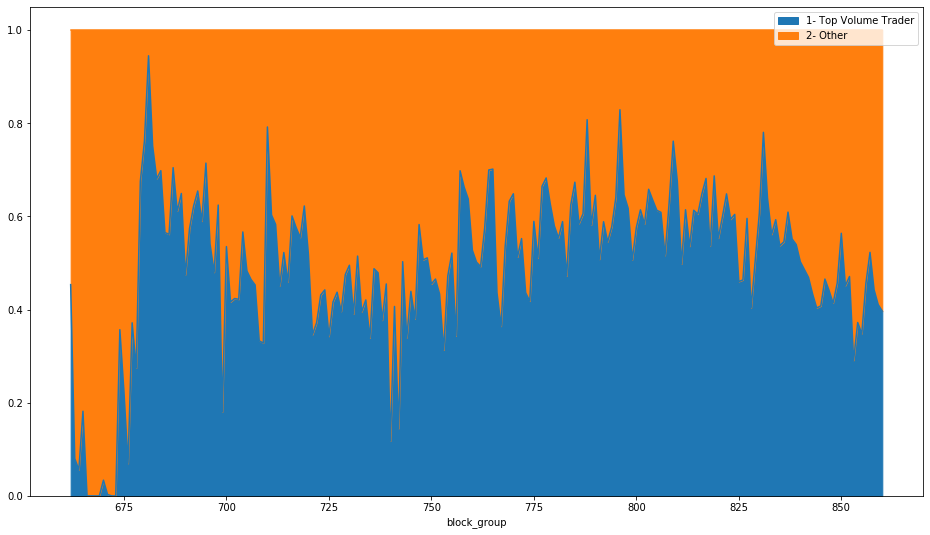

In [20]:
areaplot = trades.groupby(['block_group','agent_class_vol']).trading_volume.sum().reset_index().pivot(index='block_group', columns='agent_class_vol', values='trading_volume')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

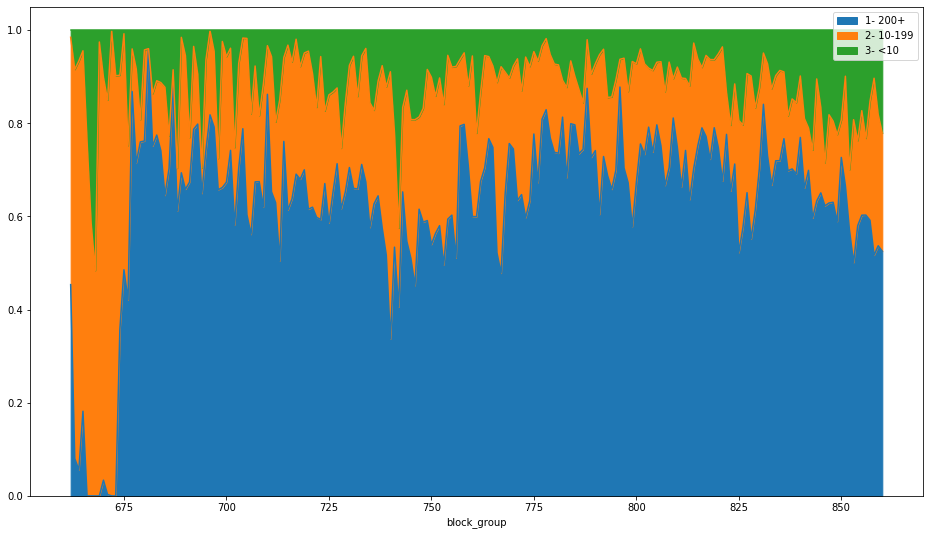

In [21]:
areaplot = trades.groupby(['block_group','agent_class_freq']).trading_volume.sum().reset_index().pivot(index='block_group', columns='agent_class_freq', values='trading_volume')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

In [22]:
trades['isRound'] = (((trades['eth_delta']%1e15)==0) | ((trades['token_delta']%1e15)==0))
trades['isRound'] = trades['isRound'].apply(lambda x: 'Round Trade' if x else 'Not Round')

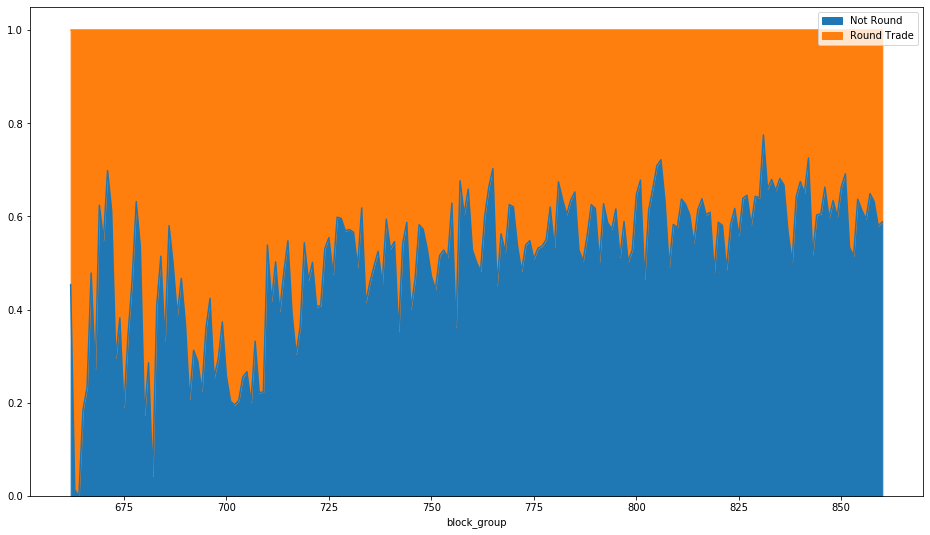

In [23]:
areaplot = trades.groupby(['block_group','isRound']).trading_volume.sum().reset_index().pivot(index='block_group', columns='isRound', values='trading_volume')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

In [24]:
trades['isDirect'] = trades['transaction_sender']==trades['agent']
trades['isDirect'] = trades['isDirect'].apply(lambda x: '2- Traded directly' if x else '1- Traded via proxy')

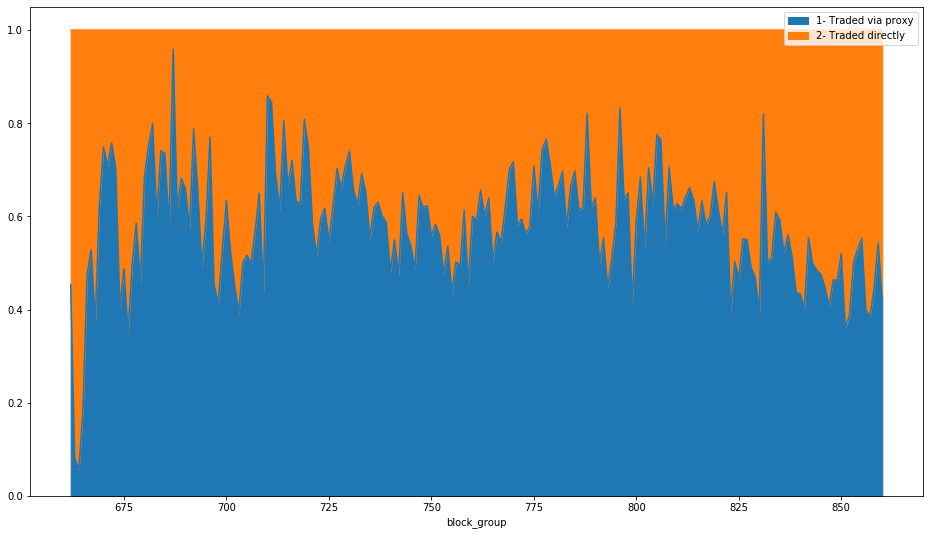

In [25]:
areaplot = trades.groupby(['block_group','isDirect']).trading_volume.sum().reset_index().pivot(index='block_group', columns='isDirect', values='trading_volume')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

## Conclusion